In [2]:
import sys 
import os
from pathlib import Path
import csv 
import requests
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib as mpl
import pylab as pl
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import akshare as ak
import sqlite3 as sql
import talib as ta
from tqdm import tqdm
from itertools import combinations
from sklearn.preprocessing import OrdinalEncoder
from datetime import datetime,timedelta
plt.rcParams['font.sans-serif'] = ['SimHei']
pd.set_option('display.unicode.east_asian_width',True)
plt.rcParams['axes.unicode_minus']=False
mpl.use('TkAgg')

In [3]:
all_A_listed = ak.stock_zh_a_spot_em()
conn = sql.connect('symbol.db')
all_A_symbols = all_A_listed[['代码', '名称']].sort_values('代码')
# all_A_symbols.to_sql(name='symbols', con=conn, if_exists='append')
all_A_listed=all_A_listed.sort_values('代码')
#股票

sse=ak.stock_sh_a_spot_em()
sse
szse=ak.stock_sz_a_spot_em()
szse
bse=ak.stock_bj_a_spot_em()
bse
ex = input('exchange:(可输入sse，szse和bse，其他输入默认为所有交易所股票)')
if ex =='sse':
    stock_ex=sse
elif ex=='szse':
    stock_ex=szse
elif ex=='bse':
    stock_ex=bse
else:
    stock_ex=all_A_listed

com_data=all_A_listed['代码'].tolist()

stock_ex=stock_ex.dropna()
stock_ex

exchange:(可输入sse，szse和bse，其他输入默认为所有交易所股票) 


,序号,代码,名称,最新价,涨跌幅,涨跌额,成交量,成交额,振幅,最高,...,量比,换手率,市盈率-动态,市净率,总市值,流通市值,涨速,5分钟涨跌,60日涨跌幅,年初至今涨跌幅
1547,1548,000001,平安银行,9.50,-2.06,-0.20,1579122.0,1.515157e+09,2.16,9.70,...,0.81,0.81,3.49,0.47,1.843562e+11,1.843527e+11,-0.11,0.00,-11.13,1.17
2223,2224,000002,万 科Ａ,9.79,-2.68,-0.27,797927.0,7.903654e+08,2.58,10.05,...,0.68,0.82,6.43,0.46,1.168016e+11,9.512617e+10,-0.20,-0.10,-18.21,-6.41
5439,5440,000004,国华网安,13.72,-7.92,-1.18,80857.0,1.147231e+08,8.59,15.00,...,0.93,6.40,-38.70,5.72,1.816257e+09,1.732673e+09,0.00,-0.15,-17.99,-14.94
1482,1483,000005,ST星源,0.99,-1.98,-0.02,91218.0,9.098760e+06,4.95,1.02,...,0.61,0.86,-93.87,0.87,1.047951e+09,1.047367e+09,0.00,0.00,-29.79,-7.48
4959,4960,000006,深振业Ａ,4.49,-5.07,-0.24,700851.0,3.231199e+08,8.88,4.90,...,1.20,5.19,-3708.94,0.78,6.061478e+09,6.061443e+09,-0.44,-0.44,-0.22,-2.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5373,5374,873693,阿为特,35.83,-6.72,-2.58,26719.0,9.445258e+07,13.95,38.39,...,0.98,13.16,96.38,8.13,2.604841e+09,7.273490e+08,0.00,2.46,26.25,-13.75
5337,5338,873703,广厦环能,30.70,-6.40,-2.10,13711.0,4.301298e+07,9.82,33.25,...,1.19,6.54,13.86,2.55,2.360830e+09,6.440860e+08,0.62,0.62,30.92,-20.22
216,217,873726,卓兆点胶,30.32,0.97,0.29,11560.0,3.490046e+07,7.86,31.43,...,0.73,6.63,28.09,4.14,2.488582e+09,5.288237e+08,-0.10,-0.82,38.32,-30.52
36,37,873806,云星宇,12.20,7.02,0.80,319262.0,3.758261e+08,11.14,12.45,...,1.27,42.04,31.11,2.65,3.536373e+09,9.265093e+08,0.66,1.33,163.50,163.50


In [4]:
stock_code=str(input('stock code:'))
#通过改变timedelta系数来确定获取几日数据（以一年为例）
today=datetime.today()
start_date = today - timedelta(days=365)
today = today.strftime('%Y%m%d')
start_date = start_date.strftime('%Y%m%d')

while True:
    if stock_code in com_data:
        
        stock_data_spe=ak.stock_zh_a_hist(symbol=stock_code, period="daily", start_date=start_date, end_date=today)
    
        com_name=ak.stock_individual_info_em(symbol=stock_code).loc[5,'value']

        break
    else:
        print('wrong stock code,input a correct code again:')
        stock_code=input()

stock_data_spe.fillna(0,inplace=True)
print('股票名称：',com_name)
stock=all_A_listed[all_A_listed['代码']==stock_code]
print(stock)
stock_data_spe['市盈率']=stock['市盈率-动态'].tolist()[0]
stock_data_spe['市净率']=stock['市净率'].tolist()[0]
stock_data_spe['流通市值']=stock['流通市值'].tolist()[0]
stock_data_spe['日期']=pd.to_datetime(stock_data_spe['日期'])
stock_data_spe['量比']=stock['量比'].tolist()[0]

stock_data_spe

stock code: 688255


股票名称： 凯尔达
      序号    代码    名称  最新价  涨跌幅  涨跌额  成交量      成交额  振幅  \
2156  2157  688255  凯尔达   18.12   -2.63   -0.49  6810.0  12515974.0  4.89   

       最高  ...  量比  换手率  市盈率-动态  市净率        总市值  \
2156  18.95  ...  0.63    0.97        91.13    1.79  1.990643e+09   

          流通市值  涨速  5分钟涨跌  60日涨跌幅  年初至今涨跌幅  
2156  1.270258e+09   0.0       0.11      -30.31          -25.89  

[1 rows x 23 columns]


,日期,开盘,收盘,最高,最低,成交量,成交额,振幅,涨跌幅,涨跌额,换手率,市盈率,市净率,流通市值,量比
0,2023-01-30,37.87,36.71,38.00,36.50,18467,68366744.0,4.02,-1.63,-0.61,3.75,91.13,1.79,1.270258e+09,0.63
1,2023-01-31,38.10,36.50,38.10,36.40,11595,42971882.0,4.63,-0.57,-0.21,2.35,91.13,1.79,1.270258e+09,0.63
2,2023-02-01,37.01,37.37,37.78,36.11,16282,60280808.0,4.58,2.38,0.87,3.30,91.13,1.79,1.270258e+09,0.63
3,2023-02-02,37.41,36.92,37.81,36.90,14681,54588536.0,2.44,-1.20,-0.45,2.98,91.13,1.79,1.270258e+09,0.63
4,2023-02-03,36.80,37.66,37.77,36.59,13247,49324714.0,3.20,2.00,0.74,2.69,91.13,1.79,1.270258e+09,0.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2024-01-24,19.07,18.31,19.19,17.77,17869,32702856.0,7.45,-3.88,-0.74,2.55,91.13,1.79,1.270258e+09,0.63
245,2024-01-25,18.67,19.49,19.51,18.34,11216,21315399.0,6.39,6.44,1.18,1.60,91.13,1.79,1.270258e+09,0.63
246,2024-01-26,19.58,19.41,19.90,19.20,8884,17305782.0,3.59,-0.41,-0.08,1.27,91.13,1.79,1.270258e+09,0.63
247,2024-01-29,19.47,18.61,19.56,18.51,7834,14774468.0,5.41,-4.12,-0.80,1.12,91.13,1.79,1.270258e+09,0.63


In [49]:
# EMA(Exponential Moving Average), 指数移动平均线
num_periods_fast = 10  # 快速EMA的时间周期，10
# K:平滑常数，常取2/(n+1)
K_fast = 2 / (num_periods_fast + 1)  # 快速EMA平滑常数
ema_fast = 0
num_periods_slow = 40  # 慢速EMA的时间周期，40
K_slow = 2 / (num_periods_slow + 1)  # 慢速EMA平滑常数
ema_slow = 0
num_periods_macd = 20  # MACD EMA的时间周期，20
K_macd = 2 / (num_periods_macd + 1)  # MACD EMA平滑常数
ema_macd = 0

ema_fast_values = []  
ema_slow_values = []  
macd_values = []  
macd_signal_values = []  
# MACD - MACD-EMA
MACD_hist_values = []  
for close_price in stock_data_spe['收盘']:
    if ema_fast == 0:  # 第一个值
        ema_fast = close_price
        ema_slow = close_price
    else:
        ema_fast = (close_price - ema_fast) * K_fast + ema_fast
        ema_slow = (close_price - ema_slow) * K_slow + ema_slow

    ema_fast_values.append(ema_fast)
    ema_slow_values.append(ema_slow)

	# MACD is fast_MA - slow_EMA
    macd = ema_fast - ema_slow  
    if ema_macd == 0:
        ema_macd = macd
    else:
    	# signal is EMA of MACD values
        ema_macd = (macd - ema_macd) * K_macd + ema_macd  
    macd_values.append(macd)
    macd_signal_values.append(ema_macd)
    MACD_hist_values.append(macd - ema_macd)

stock_data_spe = stock_data_spe.assign(ClosePrice=pd.Series(stock_data_spe['收盘'], index=stock_data_spe.index))
stock_data_spe = stock_data_spe.assign(FastEMA10d=pd.Series(ema_fast_values, index=stock_data_spe.index))
stock_data_spe = stock_data_spe.assign(SlowEMA40d=pd.Series(ema_slow_values, index=stock_data_spe.index))
stock_data_spe = stock_data_spe.assign(MACD=pd.Series(macd_values, index=stock_data_spe.index))
stock_data_spe = stock_data_spe.assign(EMA_MACD20d=pd.Series(macd_signal_values, index=stock_data_spe.index))
stock_data_spe = stock_data_spe.assign(MACD_hist=pd.Series(MACD_hist_values, index=stock_data_spe.index))

close_price = stock_data_spe['收盘']
ema_f = stock_data_spe['FastEMA10d']
ema_s = stock_data_spe['SlowEMA40d']
macd = stock_data_spe['MACD']
ema_macd = stock_data_spe['EMA_MACD20d']
macd_hist = stock_data_spe['MACD_hist']

# 设置画布，纵向排列的三个子图
fig, ax = plt.subplots(3, 1)

# 调整子图的间距，hspace表示高(height)方向的间距
plt.subplots_adjust(hspace=.1)

# 设置第一子图的y轴信息及标题
ax[0].set_ylabel('收盘价')
ax[0].set_title('股票代码 %s  MACD 预测' % stock_code)
close_price.plot(ax=ax[0], color='k', lw=1., legend=True, use_index=False)
ema_f.plot(ax=ax[0], color='b', lw=1., legend=True, use_index=False)
ema_s.plot(ax=ax[0], color='r', lw=1., legend=True, use_index=False)

# 应用同步缩放
ax[1] = plt.subplot(312)
macd.plot(ax=ax[1], color='y', lw=1., legend=True, sharex=ax[0], use_index=False)
ema_macd.plot(ax=ax[1], color='k', lw=1., legend=True, use_index=False)

# 应用同步缩放
ax[2] = plt.subplot(313)
stock_data_spe['MACD_hist'].plot(ax=ax[2], color='r', kind='bar', legend=True, sharex=ax[0])

# 设置间隔，以便图形横坐标可以正常显示（否则数据多了x轴会重叠）
scale=len(stock_data_spe)
interval = scale // 1
# 设置x轴参数，应用间隔设置
# 时间序列转换，(否则日期默认会显示时分秒数据00:00:00)
# x轴标签旋转便于显示

pl.xticks([i for i in range(1, scale + 1, interval)],
          [datetime.strftime(i, format='%Y-%m-%d') for i in \
           pd.date_range(stock_data_spe.index[0], stock_data_spe.index[-1], freq='%dd' % (interval))],
          rotation=45)

plt.show()

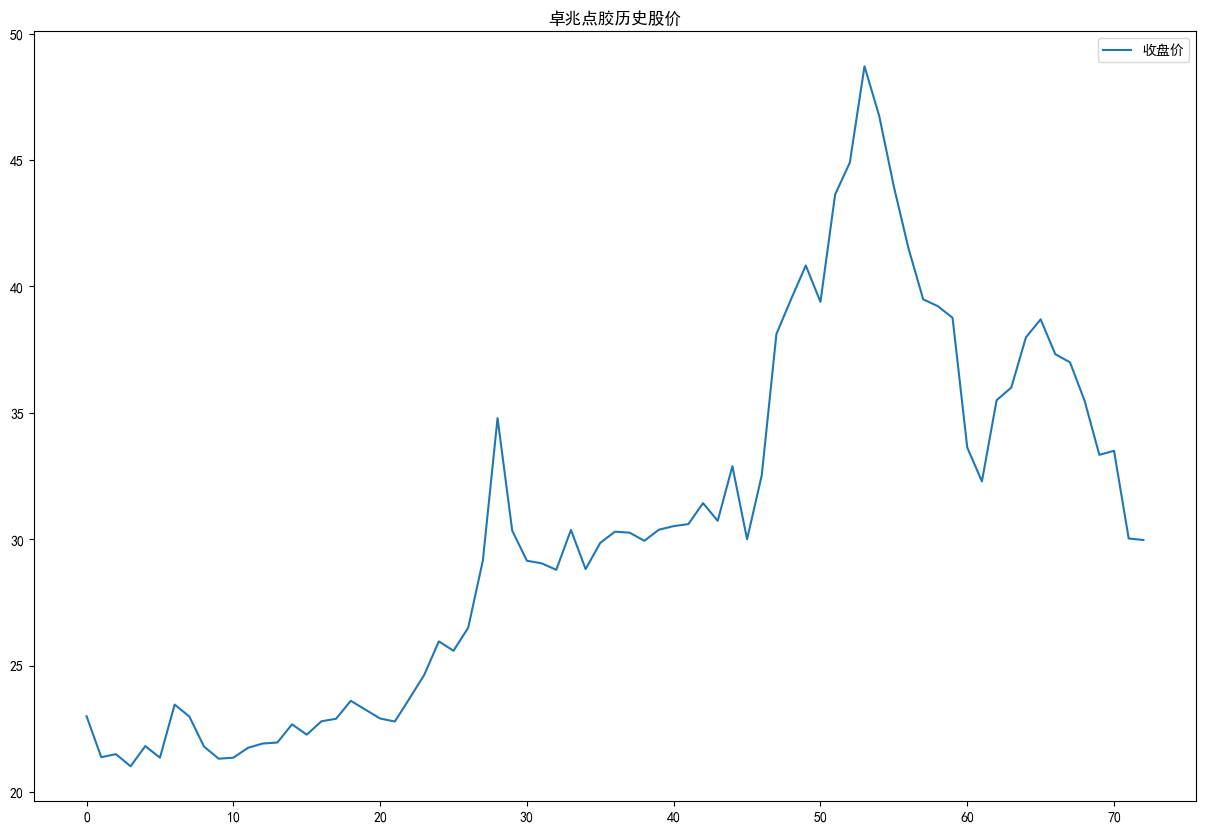